In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

games = pd.read_csv('./data/games.csv')
details = pd.read_csv('./data/games_details.csv')
injuries = pd.read_csv('./data/injuries_2010_2020.csv')

#Helper function to force pandas to display full dataframes
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [11]:
injuries

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left ...
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL


In [12]:
#We will drop the Acquired column for now, it might be possible to do analysis on 
#players returning from injuries but let's ignore it for now

injuries = injuries.drop('Acquired',axis=1)
injuries = injuries[injuries.Relinquished.notnull()]
injuries.update(injuries['Team'].fillna(value='No team', inplace=True))

#Charlotte Hornets were formerly the Bobcats before 2014, so we should count their injuries as
#part of the Hornets

injuries['Team'] = np.where((injuries.Team == 'Bobcats'), 'Hornets', injuries.Team)

#Let's copy the injuries dataset into a new dataframe
injuries_classes = injuries.copy()

#We'll use a lambda to create 3 different class labels for ML
injuries_classes['Notes'] = injuries_classes['Notes'].apply(lambda x: 
        1 if 'out for season' in x 
        else 0 if 'out indefinitely' in x
        else -1)
        
#Renaming the 'Notes' column to 'Class'
injuries_classes = injuries_classes.rename({'Notes': 'Injury', 'Relinquished': 'Player', 'year': 'Year'}, axis='columns')

#String formatting and removal of Jr. and periods from rows in Player column
injuries_classes['Player'] = injuries_classes['Player'].astype("string")
injuries_classes['Player'] = injuries_classes['Player'].str.replace('Jr.','')
injuries_classes['Player'] = injuries_classes['Player'].str.replace('.','')
injuries_classes['Player'] = injuries_classes['Player'].str.strip()

details['PLAYER_NAME'] = details['PLAYER_NAME'].astype("string")

#Formatting of both games and injuries to use pd Datetime format for merging
injuries_classes['Date'] = pd.to_datetime(injuries_classes['Date'],format='%Y-%m-%d')

games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'],format='%Y-%m-%d')

#Enumeration of NBA Season dates in a dictionary. Seems unnecessary if using
#pd.merge_asof to merge datasets
nba_seasons = {
        "2010-11": ["2010-10-26","2011-06-12"],
        "2011-12": ["2011-12-25","2012-06-21"],
        "2012-13": ["2012-10-30","2013-06-20"],
        "2013-14": ["2013-"]
}

injuries_classes

<ipython-input-12-66b62b725f2b>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  injuries_classes['Player'] = injuries_classes['Player'].str.replace('Jr.','')
<ipython-input-12-66b62b725f2b>:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  injuries_classes['Player'] = injuries_classes['Player'].str.replace('.','')


,Date,Team,Player,Injury
0,2010-10-03,Bulls,Carlos Boozer,0
1,2010-10-06,Pistons,Jonas Jerebko,0
2,2010-10-06,Pistons,Terrico White,0
3,2010-10-08,Blazers,Jeff Ayres,0
4,2010-10-08,Nets,Troy Murphy,0
...,...,...,...,...
27097,2020-09-22,Celtics,Romeo Langford,1
27098,2020-09-23,Heat,Gabe Vincent,-1
27099,2020-09-30,Heat,Bam Adebayo,-1
27101,2020-10-02,Heat,Bam Adebayo,-1


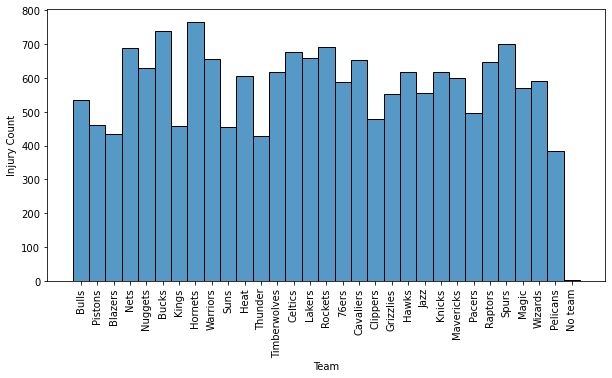

In [13]:
plt.figure(figsize=(10,5))
chart = sns.histplot(x='Team',data=injuries)
plt.xticks(rotation=90)
plt.ylabel('Injury Count')
plt.show()

In [14]:
games = games.drop_duplicates(subset=['GAME_ID'])
games = games[["GAME_DATE_EST","GAME_ID","SEASON"]]

In [15]:
df = games.sort_values(by=['GAME_DATE_EST'])
df[df.SEASON.astype(int) >= 2010]

,GAME_DATE_EST,GAME_ID,SEASON
7456,2010-10-04,11000003,2010
7448,2010-10-05,11000004,2010
7449,2010-10-05,11000007,2010
7450,2010-10-05,11000011,2010
7451,2010-10-05,11000006,2010
...,...,...,...
4,2021-05-25,42000152,2020
3,2021-05-25,42000112,2020
2,2021-05-26,42000142,2020
1,2021-05-26,42000132,2020


In [16]:
#Dataframes that are to be merged by merge_asof need to be sorted first
df = details.merge(games, on=['GAME_ID'])
df = df.sort_values(by=['GAME_DATE_EST'],ascending=True)
df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_DATE_EST,SEASON
253897,10300001,1610612762,UTA,Utah,2260,Jarron Collins,NaN,NaN,5,2.0,...,2.0,0.0,0.0,0.0,2.0,2.0,4.0,NaN,2003-10-05,2003
253896,10300001,1610612762,UTA,Utah,731,Greg Ostertag,NaN,NaN,5,1.0,...,6.0,1.0,0.0,0.0,1.0,1.0,3.0,NaN,2003-10-05,2003
253889,10300001,1610612762,UTA,Utah,2144,Ademola Okulaja,NaN,NaN,5,1.0,...,1.0,1.0,0.0,0.0,1.0,2.0,2.0,NaN,2003-10-05,2003
253890,10300001,1610612762,UTA,Utah,1905,Andrei Kirilenko,NaN,NaN,5,0.0,...,5.0,2.0,2.0,1.0,4.0,1.0,1.0,NaN,2003-10-05,2003
253891,10300001,1610612762,UTA,Utah,1052,Ben Handlogten,NaN,NaN,5,2.0,...,6.0,0.0,0.0,0.0,2.0,4.0,4.0,NaN,2003-10-05,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,42000142,1610612763,MEM,Memphis,203937,Kyle Anderson,F,NaN,36:21,5.0,...,6.0,3.0,4.0,0.0,2.0,2.0,11.0,2.0,2021-05-26,2020
58,42000132,1610612752,NYK,New York,1629033,Theo Pinson,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-26,2020
57,42000132,1610612752,NYK,New York,203658,Norvel Pelle,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-26,2020
71,42000142,1610612763,MEM,Memphis,1629723,John Konchar,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-26,2020


In [17]:
asofmerge = pd.merge_asof(injuries_classes, df, left_on=['Date'], right_on=['GAME_DATE_EST'],direction='nearest',left_by=['Player'],right_by=['PLAYER_NAME'],tolerance=pd.Timedelta("2W"))
asofmerge = asofmerge.sort_values(by=['GAME_DATE_EST'])
asofmerge[['Player','PLAYER_NAME','Team','GAME_DATE_EST','Injury','Date','FGM']]

,Player,PLAYER_NAME,Team,GAME_DATE_EST,Injury,Date,FGM
1,Jonas Jerebko,Jonas Jerebko,Pistons,2010-10-05,0,2010-10-06,1.0
2,Terrico White,Terrico White,Pistons,2010-10-05,0,2010-10-06,0.0
5,Jonas Jerebko,Jonas Jerebko,Pistons,2010-10-05,-1,2010-10-08,1.0
6,Terrico White,Terrico White,Pistons,2010-10-05,-1,2010-10-08,0.0
3,Jeff Ayres,Jeff Ayres,Blazers,2010-10-07,0,2010-10-08,0.0
...,...,...,...,...,...,...,...
17488,Danuel House,<NA>,Rockets,NaT,-1,2020-08-11,NaN
17523,Derrick Jones,<NA>,Heat,NaT,-1,2020-08-16,NaN
17534,Melvin Frazier,<NA>,Magic,NaT,-1,2020-08-22,NaN
17547,Courtney Lee,<NA>,Mavericks,NaT,1,2020-08-30,NaN


In [18]:
injuries_games = asofmerge.dropna(axis=0,how='any',subset=['PLAYER_NAME'])
injuries_games

,Date,Team,Player,Injury,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,...,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_DATE_EST,SEASON
1,2010-10-06,Pistons,Jonas Jerebko,0,11000011.0,1.610613e+09,DET,Detroit,201973.0,Jonas Jerebko,...,2.0,0.0,0.0,0.0,1.0,3.0,4.0,NaN,2010-10-05,2010.0
2,2010-10-06,Pistons,Terrico White,0,11000011.0,1.610613e+09,DET,Detroit,202358.0,Terrico White,...,0.0,1.0,0.0,0.0,2.0,1.0,0.0,NaN,2010-10-05,2010.0
5,2010-10-08,Pistons,Jonas Jerebko,-1,11000011.0,1.610613e+09,DET,Detroit,201973.0,Jonas Jerebko,...,2.0,0.0,0.0,0.0,1.0,3.0,4.0,NaN,2010-10-05,2010.0
6,2010-10-08,Pistons,Terrico White,-1,11000011.0,1.610613e+09,DET,Detroit,202358.0,Terrico White,...,0.0,1.0,0.0,0.0,2.0,1.0,0.0,NaN,2010-10-05,2010.0
3,2010-10-08,Blazers,Jeff Ayres,0,11000021.0,1.610613e+09,POR,Portland,201965.0,Jeff Ayres,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,2010-10-07,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17554,2020-09-18,Celtics,Romeo Langford,1,41900302.0,1.610613e+09,BOS,Boston,1629641.0,Romeo Langford,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2020-09-17,2019.0
17555,2020-09-22,Celtics,Romeo Langford,1,41900302.0,1.610613e+09,BOS,Boston,1629641.0,Romeo Langford,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2020-09-17,2019.0
17557,2020-09-30,Heat,Bam Adebayo,-1,41900401.0,1.610613e+09,MIA,Miami,1628389.0,Bam Adebayo,...,4.0,0.0,0.0,0.0,0.0,2.0,8.0,-12.0,2020-09-30,2019.0
17559,2020-10-02,Heat,Goran Dragic,-1,41900401.0,1.610613e+09,MIA,Miami,201609.0,Goran Dragic,...,1.0,3.0,2.0,0.0,1.0,0.0,6.0,1.0,2020-09-30,2019.0


In [19]:
mldf = injuries_games.drop(['Date','TEAM_ABBREVIATION','TEAM_CITY','COMMENT','PLAYER_NAME','PLAYER_ID','TEAM_ID','GAME_ID','START_POSITION','GAME_DATE_EST'],axis=1)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 2000)
mldf = mldf.dropna(axis=0,how='any')
mldf['MIN'] = mldf['MIN'].astype(str)
def seconder(x):
    mins, secs = map(float, x.split(':'))
    return mins * 60 + secs
mldf['MIN'] = mldf['MIN'].apply(seconder)
mldf = mldf.rename({'MIN': 'SECS'}, axis='columns')
mldf

,Team,Player,Injury,SECS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON
79,Rockets,Yao Ming,-1,1401.0,4.0,11.0,0.364,0.0,0.0,0.0,...,7.0,11.0,2.0,0.0,2.0,4.0,6.0,9.0,-6.0,2010.0
91,Grizzlies,Zach Randolph,-1,926.0,1.0,6.0,0.167,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0,-9.0,2010.0
92,Hawks,Maurice Evans,-1,875.0,3.0,3.0,1.000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,8.0,2010.0
107,Warriors,Jeff Adrien,-1,48.0,0.0,0.0,0.000,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2010.0
99,Celtics,Jermaine O'Neal,-1,742.0,1.0,2.0,0.500,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,3.0,6.0,2.0,-6.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17551,Bucks,Giannis Antetokounmpo,-1,689.0,8.0,10.0,0.800,1.0,1.0,1.0,...,3.0,4.0,0.0,1.0,1.0,0.0,1.0,19.0,2.0,2019.0
17554,Celtics,Romeo Langford,1,81.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2019.0
17555,Celtics,Romeo Langford,1,81.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2019.0
17557,Heat,Bam Adebayo,-1,1270.0,2.0,8.0,0.250,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,0.0,2.0,8.0,-12.0,2019.0


# Performance Analysis

Performance Analysis can be done by using various data elements from the dataset. We are trying to use various parameters in the dataset to check which parameter is the most responsible towards measuring the performance of a team.
One of the data element which we used is "Injuries"

1. 1st approach is to check the total points scored by every team for all the years.
2. Using that analysis we can know which were to top and the least performing team.
3. We will then use the "Injury" data element to check the most number of injuries of a team and for which year and pick the top3 teams which had the most injuries.
4. Based on that we will check those top 3 teams having the most number of injuries and see if they are the least performing teams for that year.
4. If those team match with the teams which are the least performing then "Injury" can be considered as a performance parameter.

In [25]:
mldf.loc['Teams'].shape

KeyError: 'Teams'

In [20]:
## Sanity check to see if there is any nans
mldf.isna().sum()

Team          0
Player        0
Injury        0
SECS          0
FGM           0
FGA           0
FG_PCT        0
FG3M          0
FG3A          0
FG3_PCT       0
FTM           0
FTA           0
FT_PCT        0
OREB          0
DREB          0
REB           0
AST           0
STL           0
BLK           0
TO            0
PF            0
PTS           0
PLUS_MINUS    0
SEASON        0
dtype: int64

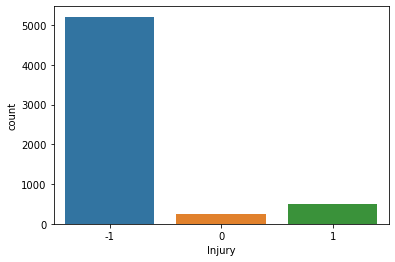

In [21]:
## Total count of players who are "Injured","Indefinitely out", "Not injured"
sns.countplot(x='Injury',data = mldf)
plt.xticks(rotation=0)
plt.show()

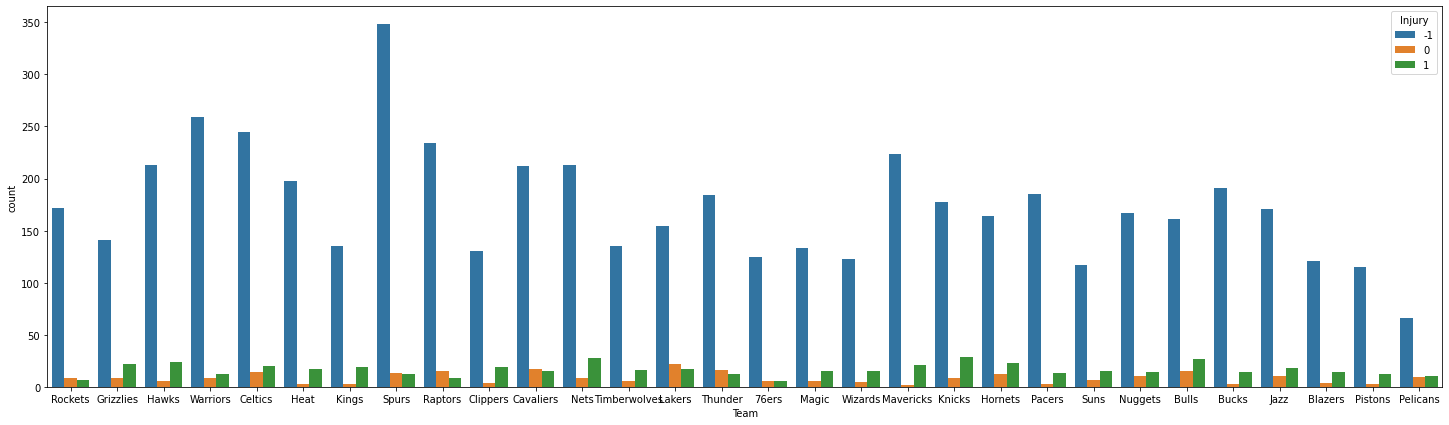

In [22]:
## By visualizing the plots, the top 3 teams which had the most number of injuries were : "Knicks(29)","Nets(28)","Bulls(25)""
## The top 3 teams which had the least number of injuries were : "Spurs(348)","Warriors(259)","Celtics(242)"

fig, scatter = plt.subplots(figsize = (25,7))
scatter=sns.countplot(x='Team',data = mldf,hue = 'Injury')
plt.xticks(rotation=0)
plt.show()

In [26]:
##Creating a dataset to filter the top 3 Teams having highest injuries and adding the seasons column to it.


## Creating dataframe for Knicks
mldf_Knicks = mldf.loc[(mldf['Team']=='Knicks') & 
                         (mldf['Injury'] == 1) ,['Team','Injury','SEASON']]
#rename columns
mldf_Knicks = mldf_Knicks.rename(columns={'Team':'Team_mldf','Injury':'Injury_mldf','SEASON':'SEASON_mldf'})
#add new column 
#reorder columns
mldf_Knicks = mldf_Knicks[['Team_mldf','Injury_mldf','SEASON_mldf']]



## Creating dataframe for Nets
mldf_Nets = mldf.loc[(mldf['Team']=='Nets') & 
                         (mldf['Injury'] == 1) ,['Team','Injury','SEASON']]
#rename columns
mldf_Nets = mldf_Nets.rename(columns={'Team':'Team_mldf','Injury':'Injury_mldf','SEASON':'SEASON_mldf'})
#add new column 
#reorder columns
mldf_Nets = mldf_Nets[['Team_mldf','Injury_mldf','SEASON_mldf']]

## Creating dataframe for Bulls
mldf_Bulls = mldf.loc[(mldf['Team']=='Bulls') & 
                         (mldf['Injury'] == 1) ,['Team','Injury','SEASON']]
#rename columns
mldf_Bulls = mldf_Bulls.rename(columns={'Team':'Team_mldf','Injury':'Injury_mldf','SEASON':'SEASON_mldf'})
#add new column 
#reorder columns
mldf_Bulls = mldf_Bulls[['Team_mldf','Injury_mldf','SEASON_mldf']]

In [27]:
mldf_top3_injuries= pd.concat([mldf_Knicks, mldf_Nets,mldf_Bulls])

In [28]:
mldf_top3_injuries.head()

,Team_mldf,Injury_mldf,SEASON_mldf
1267,Knicks,1,2010.0
3650,Knicks,1,2011.0
3662,Knicks,1,2011.0
3681,Knicks,1,2011.0
3678,Knicks,1,2011.0


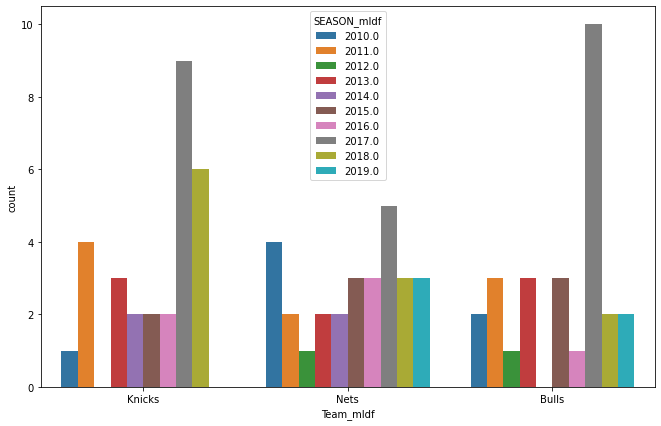

In [29]:
#Visualizing the SEASON when the top 3 teams had the most injuries.
# From the figure it is evident that all the 3 teams had the most number of injuries in the year 2017 with "Bulls" having
## the highest number of injuries (10), followed by "Knicks(9) and Nets(5)"
fig, scatter = plt.subplots(figsize = (11,7))
scatter = sns.countplot(x='Team_mldf',data = mldf_top3_injuries,hue = 'SEASON_mldf')
plt.xticks(rotation=0)
plt.show()

In [30]:
## Creating dataframe to sum the total points of all the teams

sum_mldf1 = mldf.groupby(['Team'],as_index=False)['PTS'].sum()
sum_mldf1.head()

,Team,PTS
0,76ers,1273.0
1,Blazers,1074.0
2,Bucks,1556.0
3,Bulls,1706.0
4,Cavaliers,1605.0


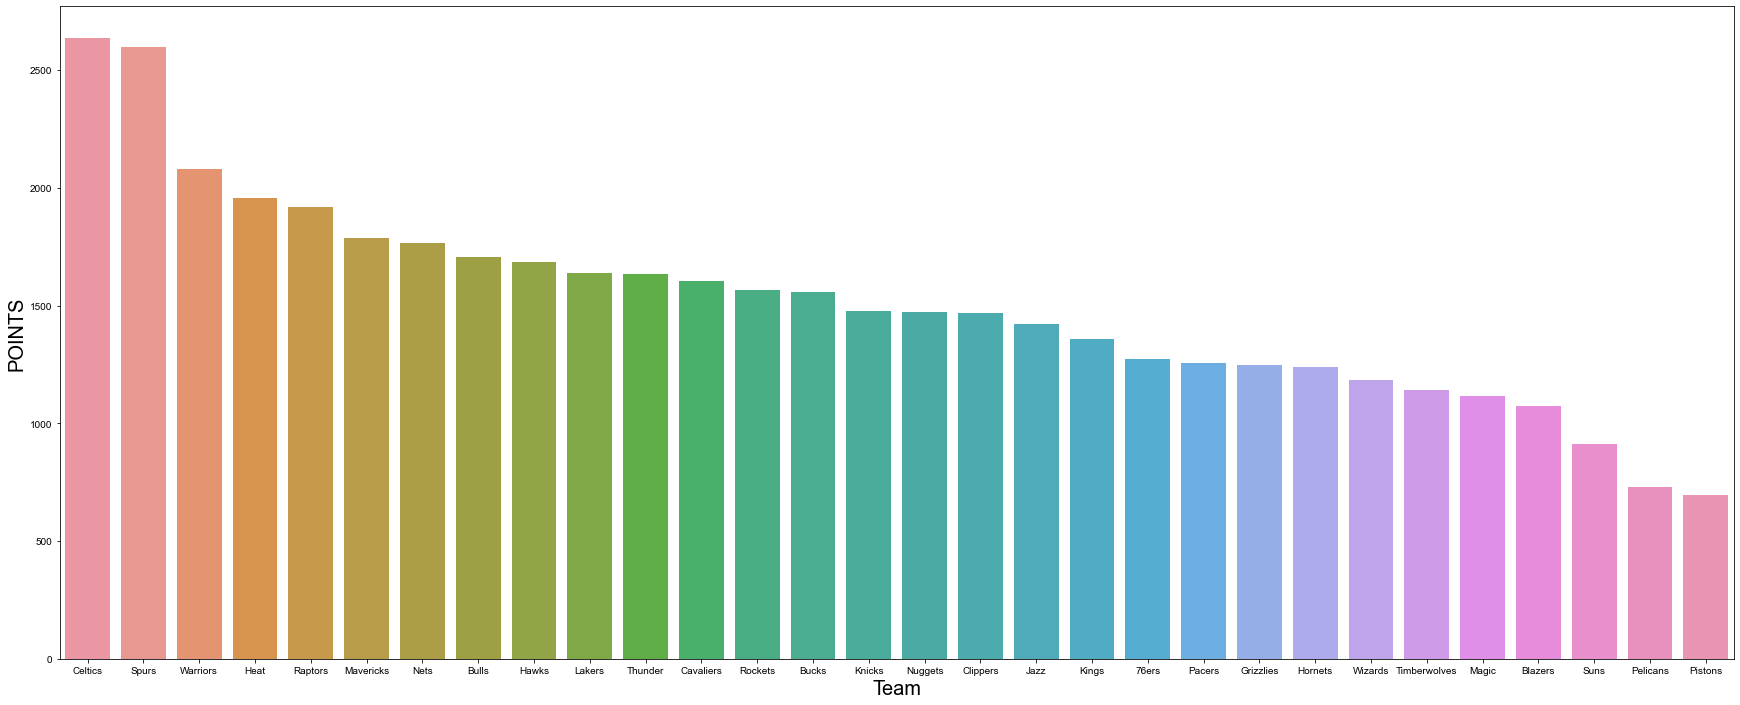

In [31]:
## The below figure shows the top and least performing teams

fig, scatter = plt.subplots(figsize = (30,12))
scatter = sns.barplot(x="Team", y="PTS", data=sum_mldf1, order=sum_mldf1.sort_values('PTS',ascending = False).Team)
sns.set( rc = {'axes.labelsize' : 20 })
scatter.set_xlabel("Team", fontsize = 20)
scatter.set_ylabel("POINTS", fontsize = 20)
plt.xticks(rotation=0)
plt.show()

In [32]:
## Creating a dataframe to sum the points of different teams grouped by Seasons

sum_mldf = mldf.groupby(['Team','SEASON'],as_index=False)['PTS'].sum()
sum_mldf

,Team,SEASON,PTS
0,76ers,2010.0,57.0
1,76ers,2011.0,31.0
2,76ers,2012.0,12.0
3,76ers,2013.0,7.0
4,76ers,2014.0,32.0
...,...,...,...
292,Wizards,2015.0,139.0
293,Wizards,2016.0,240.0
294,Wizards,2017.0,169.0
295,Wizards,2018.0,99.0


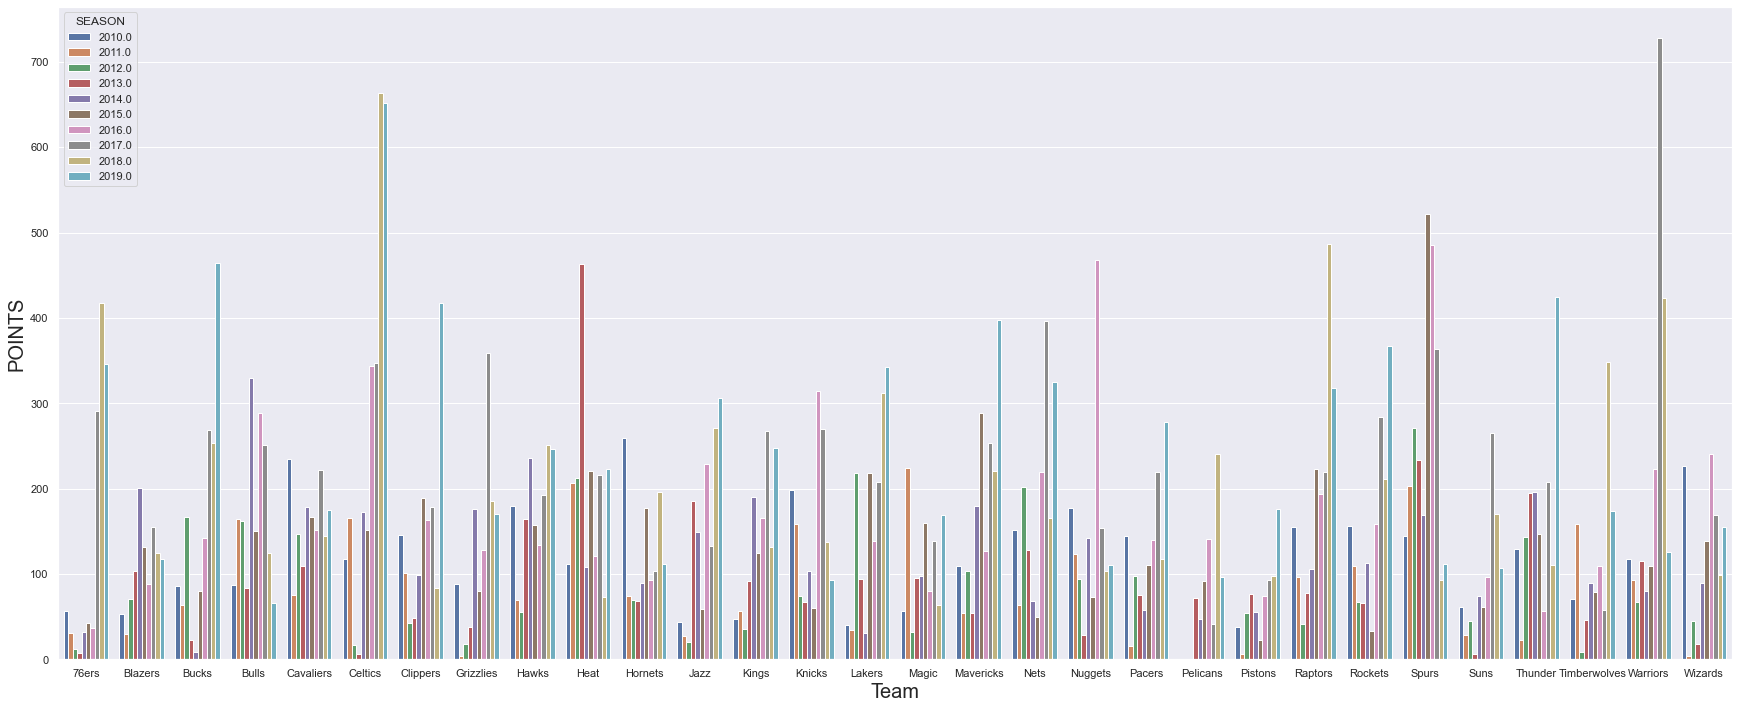

In [33]:
## As we had got the top 3 teams with the maximum number of injuries in the Season 2017, we will compare the same teams 
## to see of they are the least performing teams in terms of points scored in 2017. As per the figure below it is evident
## that least performing teams for the season 2017 are "Pelicans","Timberwolves","Pistons".
## This proves that "Injury" is not the only parameter for measuring the performance of a team.


fig, scatter = plt.subplots(figsize = (30,12))
scatter = sns.barplot(x="Team", y="PTS",hue= 'SEASON', data=sum_mldf)
sns.set( rc = {'axes.labelsize' : 20 })
scatter.set_xlabel("Team", fontsize = 20)
scatter.set_ylabel("POINTS", fontsize = 20)
plt.xticks(rotation=0)
plt.show()

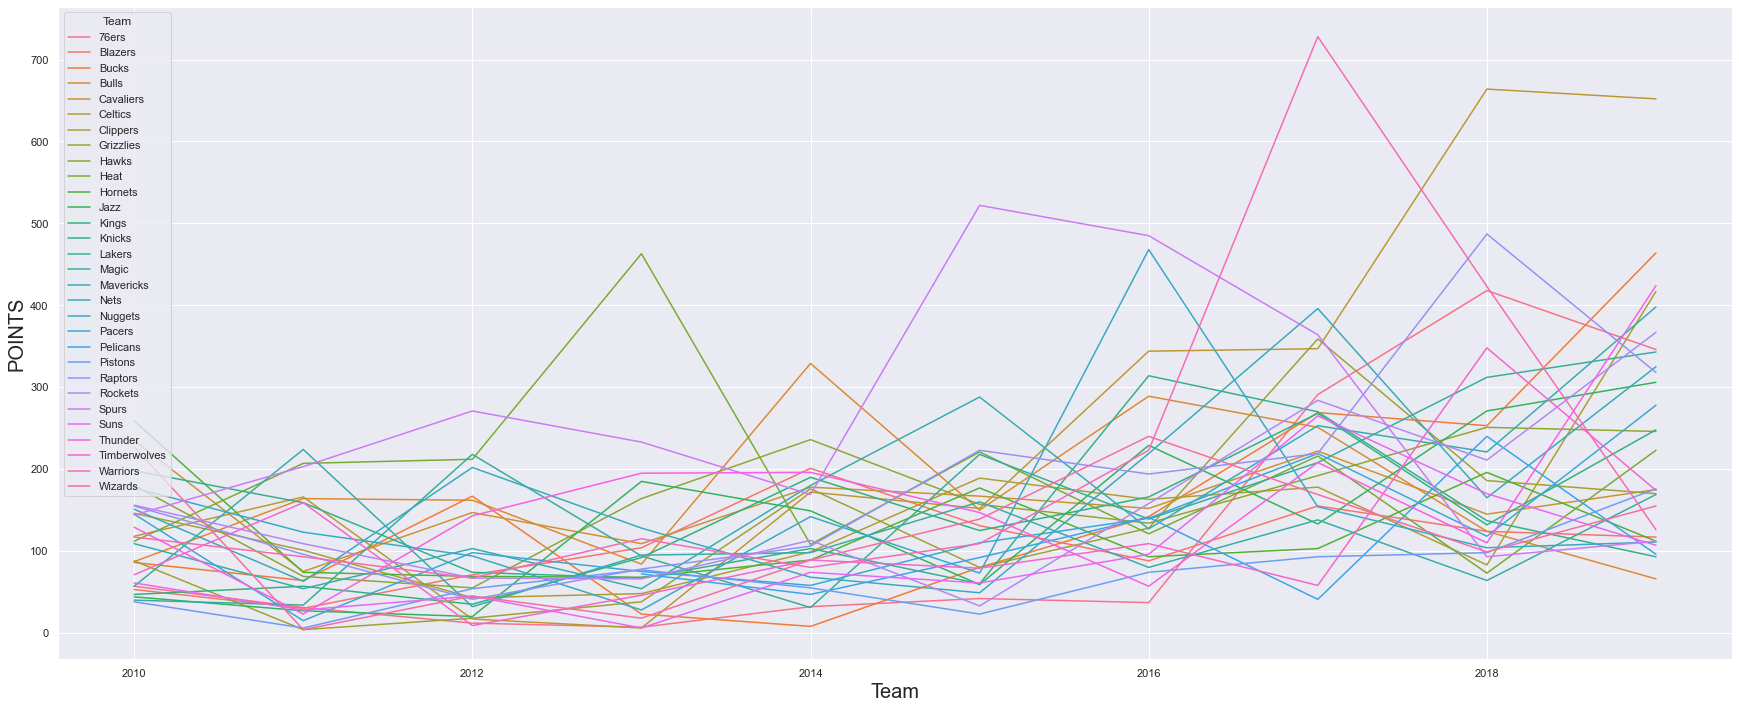

In [37]:
fig, scatter = plt.subplots(figsize = (30,12))
scatter = sns.lineplot(x="SEASON", y="PTS",hue= 'Team', data=sum_mldf)
sns.set( rc = {'axes.labelsize' : 20 })
scatter.set_xlabel("Team", fontsize = 20)
scatter.set_ylabel("POINTS", fontsize = 20)
plt.xticks(rotation=0)
plt.show()

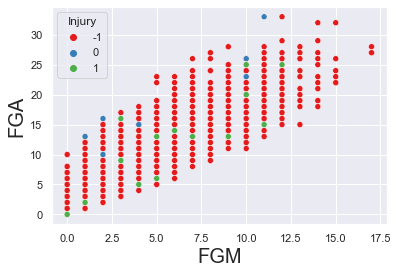

In [34]:
## Trying to visualize the Relation between Field Goal Made(FGM) and Field Goal Attempt(FGA) in terms of Injury, and 
## we can see that there is a linear correlation between FGM and FGA.

sns.scatterplot(x='FGM',y='FGA',data=mldf,palette='Set1',hue = 'Injury')

In [ ]:
## By plotting a scatter plot with FGM as X-axis and FGA as y-axis with respect to Injury, we can see that
## the year 2017 and 2018 has the most injuries.

sns.relplot(x="FGM",y="FGA",col="Injury",hue="SEASON",
           kind="scatter",data = mldf,sizes=(80,200),palette='Set2')
plt.show()

In [ ]:
## By plotting a scatter plot with FG3M as X-axis and FG3A as y-axis with respect to Injury, we can see that
## the year 2018 has the most injuries

sns.relplot(x="FG3M",y="FG3A",col="Injury",hue="SEASON",
           kind="scatter",data = mldf,sizes=(80,200),palette='Set2')
plt.show()

In [ ]:
## By plotting a scatter plot with FTM as X-axis and FTA as y-axis with respect to Injury, we can see that
## the year 2018 has the most injuries

sns.relplot(x="FTM",y="FTA",col="Injury",hue="SEASON",
           kind="scatter",data = mldf,sizes=(80,200),palette='Set2')
plt.show()